# Workshop 5: Formulating Hypothesis and MVT

__A/B Testing__
Suppose you have a predicted churn with 95% accuracy. By calling customers who are likely to churn and giving them 
attractive offers you are assuming 10% of them will retain and will bring 20 USD of revenue per customer.But, these are a lot of 
assumptions:-
- Firstly, the model accuracy is 95%. Next months their will be new customers, new campaigns,new product features, 
marketing & brand activities, new seasonality and so on. Historical and real accuracy rarely match in these scenarios.so, 
we can't provide any conclusion without any conclusion.
- Next, we are assuming that there will be 10% conversion. But, we cannot that your new action will have 10% conversion 
due to the factors above.Moreover, since it is a new group their actions are unpredictable.
- Finally, we are assuming that each of these customers will bring 20 USD as monthly revenue. But, it doesn't mean they will
bring the same after your new action.
And to see what is going to happen we perform an A/B Test.

Going forward with the example above, our hypothesis is, test group will have more retention:
Group A → Offer → Higher Retention
Group B → No offer → Lower Retention
This also helps us to test model accuracy as well. If group B’s retention rate is 50%, it clearly shows that our model is not 
working. The same applies to measure revenue coming from those users too.
In this case our success metric will be retention rate of both groups.

In [1]:
#import libraries
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Now we are going to create our own dataset. The dataset will contain the columns below:
- customer_id: the unique identifier of the customer
- segment: customer’s segment; high-value or low-value
- group: indicates whether the customer is in the test or control group
- purchase_count: # of purchases completed by the customer

In [2]:
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['group'] = 'control'
df_hv.loc[df_hv.index<10000,'group'] = 'test'

Ideally, purchase count should be a Poisson distribution. There will be customers with no purchase and we will have less
customers with high purchase counts. Let’s use numpy.random.poisson() for doing that and assign different 
distributions to test and control group:

In [3]:
df_hv.loc[df_hv.group == 'test', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'control', 'purchase_count'] = np.random.poisson(0.5, 10000)

In [4]:
df_hv.head(10)

,customer_id,segment,group,purchase_count
0,0,high-value,test,1.0
1,1,high-value,test,0.0
2,2,high-value,test,2.0
3,3,high-value,test,0.0
4,4,high-value,test,1.0
5,5,high-value,test,0.0
6,6,high-value,test,0.0
7,7,high-value,test,2.0
8,8,high-value,test,0.0
9,9,high-value,test,0.0


In [5]:
df_hv.tail(10)

,customer_id,segment,group,purchase_count
19990,19990,high-value,control,0.0
19991,19991,high-value,control,1.0
19992,19992,high-value,control,0.0
19993,19993,high-value,control,0.0
19994,19994,high-value,control,0.0
19995,19995,high-value,control,1.0
19996,19996,high-value,control,0.0
19997,19997,high-value,control,0.0
19998,19998,high-value,control,1.0
19999,19999,high-value,control,0.0


__High Value Customer Test Vs Control Group Comparison__

In [6]:
#Assume we applied an offer to 50% of high-value users and observed their purchases in a given period. 
#Best way to visualize it to check the densities:
test_results = df_hv[df_hv.group == 'test'].purchase_count
control_results = df_hv[df_hv.group == 'control'].purchase_count

hist_data = pd.DataFrame(list(zip(test_results, control_results)),columns=['test', 'control'])

#group_labels = ['test', 'control']

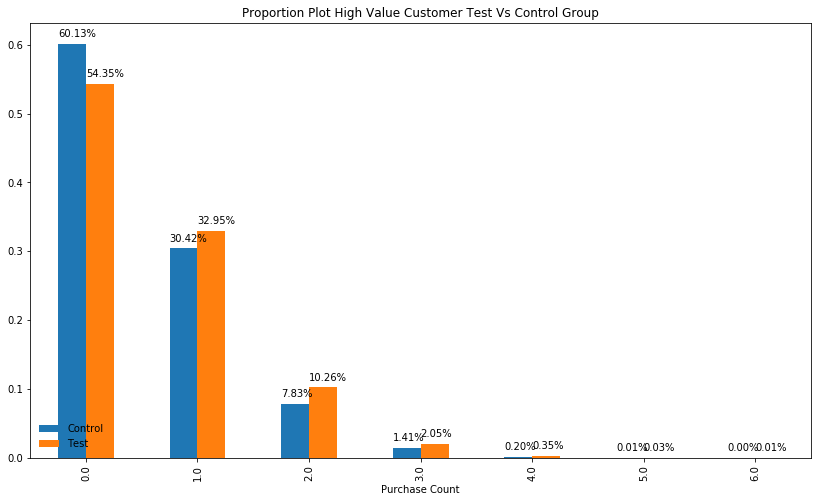

In [7]:
fig,ax = plt.subplots(figsize=(14,8))
table = pd.crosstab(df_hv["group"],df_hv["purchase_count"])
pd.crosstab(df_hv["group"],df_hv["purchase_count"]).div(table.sum(1).astype(float), axis=0).T.plot(kind='bar',ax=ax)
plt.title("Proportion Plot High Value Customer Test Vs Control Group")
plt.xlabel("Purchase Count")
plt.legend(["Control","Test"],loc='lower left',frameon=False)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(height), (x, y + height + 0.01))
plt.show() 

In [8]:
table

purchase_count,0.0,1.0,2.0,3.0,4.0,5.0,6.0
group,,,,,,,
control,6013,3042,783,141,20,1,0
test,5435,3295,1026,205,35,3,1


The results are looking really good. The density of the test group’s purchase is better starting from 1. 
But how we can certainly say this experiment is successful and the difference didn’t happen due to other factors?
To answer this question, we need to check if the uptick in the test group is statistically significant. For this we will perform
t-test.

In [9]:
from scipy import stats 
test_result = stats.ttest_ind(test_results, control_results)
print(test_result)

Ttest_indResult(statistic=9.45730648727188, pvalue=3.4988308783027235e-21)


ttest_ind() method returns two output:
t-statistic: represents the difference between averages of test and control group in units of standard error. 
Higher t-statistic value means bigger difference and supports our hypothesis.
p-value: measures the probability of the null hypothesis to be true.
If null hypothesis is true, it means there is no significant difference between your test and control group. So the lower 
p-value means the better. As the industry standard, we accept that p-value<5% makes the result statistically significant 
(but it depends on your business logic, there are cases that people use 10% or even 1%)

In [10]:
def eval_test(test_results,control_results):
    test_result = stats.ttest_ind(test_results, control_results)
    if test_result[1] < 0.05:
        print('result is significant')
    else:
        print('result is not significant')

In [11]:
eval_test(test_result,control_results)

result is significant


__Blocking__

In [12]:
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['prev_purchase_count'] = np.random.poisson(0.9, 20000)


df_lv = pd.DataFrame()
df_lv['customer_id'] = np.array([count for count in range(20000,100000)])
df_lv['segment'] = np.array(['low-value' for _ in range(80000)])
df_lv['prev_purchase_count'] = np.random.poisson(0.3, 80000)

df_customers = pd.concat([df_hv,df_lv],axis=0)

In [13]:
df_customers.head()
#df_customers.shape

,customer_id,segment,prev_purchase_count
0,0,high-value,0
1,1,high-value,0
2,2,high-value,2
3,3,high-value,2
4,4,high-value,0


In [14]:
df_customers.tail()

,customer_id,segment,prev_purchase_count
79995,99995,low-value,0
79996,99996,low-value,0
79997,99997,low-value,0
79998,99998,low-value,0
79999,99999,low-value,0


In [15]:
len(df_customers)

100000

In [16]:
df_test = df_customers.sample(frac=0.9)
df_control = df_customers[~df_customers.customer_id.isin(df_test.customer_id)]

In [17]:
df_test.segment.value_counts()

low-value     72026
high-value    17974
Name: segment, dtype: int64

In [18]:
df_control.segment.value_counts()

low-value     7974
high-value    2026
Name: segment, dtype: int64

In [19]:
df_test_hv = df_customers[df_customers.segment == 'high-value'].sample(frac=0.9)
df_test_lv = df_customers[df_customers.segment == 'low-value'].sample(frac=0.9)

df_test = pd.concat([df_test_hv,df_test_lv],axis=0)
df_control = df_customers[~df_customers.customer_id.isin(df_test.customer_id)]

In [20]:
df_test.segment.value_counts()

low-value     72000
high-value    18000
Name: segment, dtype: int64

In [21]:
df_control.segment.value_counts()

low-value     8000
high-value    2000
Name: segment, dtype: int64

In [22]:
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(30000)])
df_hv['segment'] = np.array(['high-value' for _ in range(30000)])
df_hv['group'] = 'A'
df_hv.loc[df_hv.index>=10000,'group'] = 'B' 
df_hv.loc[df_hv.index>=20000,'group'] = 'C'


In [23]:
df_hv.group.value_counts()

A    10000
C    10000
B    10000
Name: group, dtype: int64

In [24]:
df_hv.loc[df_hv.group == 'A', 'purchase_count'] = np.random.poisson(0.4, 10000)
df_hv.loc[df_hv.group == 'B', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'C', 'purchase_count'] = np.random.poisson(0.2, 10000)

In [25]:

a_stats = df_hv[df_hv.group=='A'].purchase_count
b_stats = df_hv[df_hv.group=='B'].purchase_count
c_stats = df_hv[df_hv.group=='C'].purchase_count

hist_data = [a_stats, b_stats, c_stats]

group_labels = ['A', 'B','C']

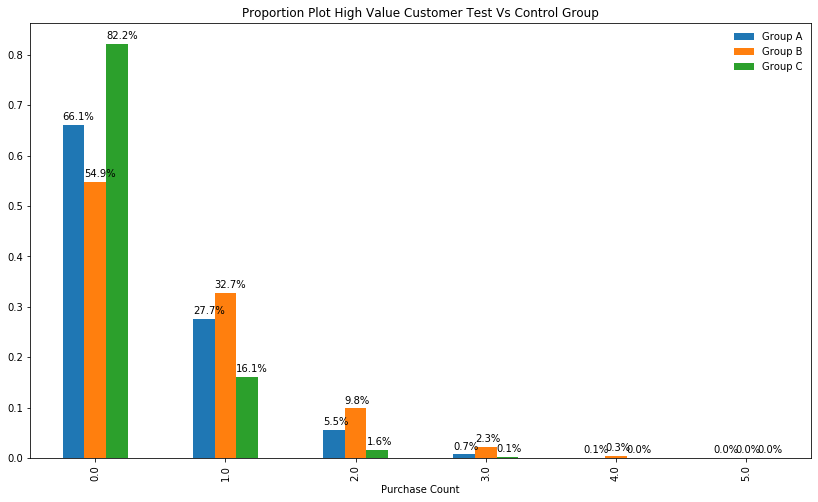

In [26]:
fig,ax = plt.subplots(figsize=(14,8))
table = pd.crosstab(df_hv["group"],df_hv["purchase_count"])
pd.crosstab(df_hv["group"],df_hv["purchase_count"]).div(table.sum(1).astype(float), axis=0).T.plot(kind='bar',ax=ax)
plt.title("Proportion Plot High Value Customer Test Vs Control Group")
plt.xlabel("Purchase Count")
plt.legend(["Group A","Group B","Group C"],loc='best',frameon=False)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.1%}'.format(height), (x, y + height + 0.01))
plt.show() 

In [27]:
def one_anova_test(a_stats,b_stats,c_stats):
    test_result = stats.f_oneway(a_stats, b_stats, c_stats)
    if test_result[1] < 0.05:
        print('result is significant')
    else:
        print('result is not significant')

In [28]:
one_anova_test(a_stats,b_stats,c_stats)

result is significant


In [29]:
df_hv.loc[df_hv.group == 'A', 'purchase_count'] = np.random.poisson(0.5, 10000)
df_hv.loc[df_hv.group == 'B', 'purchase_count'] = np.random.poisson(0.5, 10000)
df_hv.loc[df_hv.group == 'C', 'purchase_count'] = np.random.poisson(0.5, 10000)

In [30]:
a_stats = df_hv[df_hv.group=='A'].purchase_count
b_stats = df_hv[df_hv.group=='B'].purchase_count
c_stats = df_hv[df_hv.group=='C'].purchase_count

hist_data = [a_stats, b_stats, c_stats]

group_labels = ['A', 'B','C']

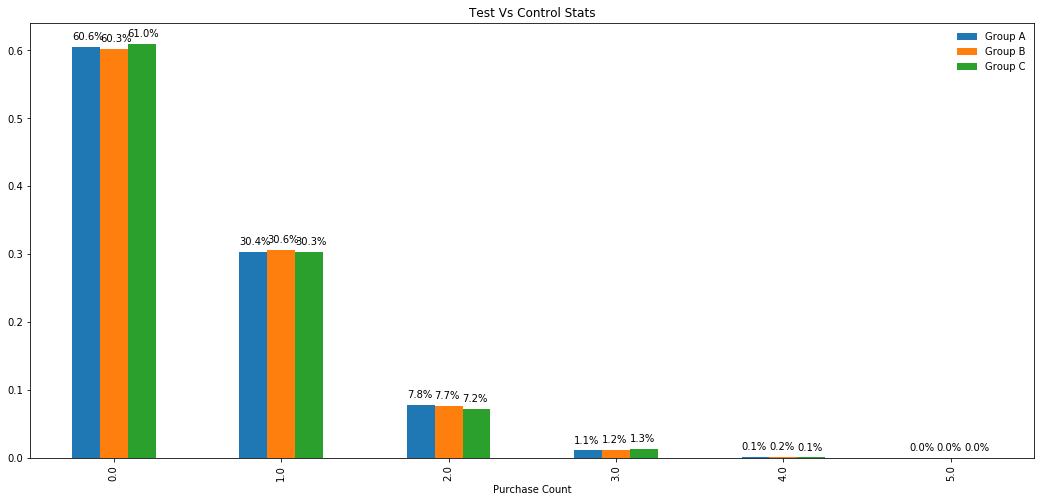

In [31]:
fig,ax = plt.subplots(figsize=(18,8))
table = pd.crosstab(df_hv["group"],df_hv["purchase_count"])
pd.crosstab(df_hv["group"],df_hv["purchase_count"]).div(table.sum(1).astype(float), axis=0).T.plot(kind='bar',ax=ax)
plt.title("Test Vs Control Stats")
plt.xlabel("Purchase Count")
plt.legend(["Group A","Group B","Group C"],loc='best',frameon=False)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.1%}'.format(height), (x, y + height + 0.01))
plt.show() 

In [32]:
one_anova_test(a_stats,b_stats,c_stats)

result is not significant


In [33]:

#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['group'] = 'control'
df_hv.loc[df_hv.index<10000,'group'] = 'test' 
df_hv.loc[df_hv.group == 'control', 'purchase_count'] = np.random.poisson(0.6, 10000)
df_hv.loc[df_hv.group == 'test', 'purchase_count'] = np.random.poisson(0.8, 10000)


df_lv = pd.DataFrame()
df_lv['customer_id'] = np.array([count for count in range(20000,100000)])
df_lv['segment'] = np.array(['low-value' for _ in range(80000)])
df_lv['group'] = 'control'
df_lv.loc[df_lv.index<40000,'group'] = 'test' 
df_lv.loc[df_lv.group == 'control', 'purchase_count'] = np.random.poisson(0.2, 40000)
df_lv.loc[df_lv.group == 'test', 'purchase_count'] = np.random.poisson(0.3, 40000)

df_customers = pd.concat([df_hv,df_lv],axis=0)

In [34]:
df_customers.head()

,customer_id,segment,group,purchase_count
0,0,high-value,test,1.0
1,1,high-value,test,1.0
2,2,high-value,test,0.0
3,3,high-value,test,0.0
4,4,high-value,test,0.0


In [35]:
import statsmodels.formula.api as smf 
from statsmodels.stats.anova import anova_lm
model = smf.ols(formula='purchase_count ~ segment + group ', data=df_customers).fit()
aov_table = anova_lm(model, typ=2)

In [36]:
print(np.round(aov_table,4))


              sum_sq       df          F  PR(>F)
segment    3144.4156      1.0  9326.0469     0.0
group       356.0509      1.0  1056.0141     0.0
Residual  33715.4773  99997.0        NaN     NaN


In [37]:
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['group'] = 'control'
df_hv.loc[df_hv.index<10000,'group'] = 'test' 
df_hv.loc[df_hv.group == 'control', 'purchase_count'] = np.random.poisson(0.8, 10000)
df_hv.loc[df_hv.group == 'test', 'purchase_count'] = np.random.poisson(0.8, 10000)


df_lv = pd.DataFrame()
df_lv['customer_id'] = np.array([count for count in range(20000,100000)])
df_lv['segment'] = np.array(['low-value' for _ in range(80000)])
df_lv['group'] = 'control'
df_lv.loc[df_lv.index<40000,'group'] = 'test' 
df_lv.loc[df_lv.group == 'control', 'purchase_count'] = np.random.poisson(0.2, 40000)
df_lv.loc[df_lv.group == 'test', 'purchase_count'] = np.random.poisson(0.2, 40000)

df_customers = pd.concat([df_hv,df_lv],axis=0)

In [38]:
import statsmodels.formula.api as smf 
from statsmodels.stats.anova import anova_lm
model = smf.ols(formula='purchase_count ~ segment + group ', data=df_customers).fit()
aov_table = anova_lm(model, typ=2)

In [39]:
print(np.round(aov_table,4))

              sum_sq       df           F  PR(>F)
segment    5750.6438      1.0  18059.7812  0.0000
group         0.0689      1.0      0.2163  0.6418
Residual  31841.3121  99997.0         NaN     NaN


In [40]:
from statsmodels.stats import power
ss_analysis = power.TTestIndPower()

In [41]:
#create hv segment
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['prev_purchase_count'] = np.random.poisson(0.7, 20000)

In [42]:
df_hv.head()

,customer_id,segment,prev_purchase_count
0,0,high-value,0
1,1,high-value,1
2,2,high-value,1
3,3,high-value,0
4,4,high-value,0


In [43]:
purchase_mean = df_hv.prev_purchase_count.mean()
purchase_std = df_hv.prev_purchase_count.std()

In [44]:
print(np.round(purchase_mean,4),np.round(purchase_std,4))

0.6976 0.8291


In [45]:
effect_size = (0.75 - purchase_mean)/purchase_std

In [46]:
alpha = 0.05
power = 0.8
ratio = 1

In [47]:
ss_result = ss_analysis.solve_power(effect_size=effect_size, power=power,alpha=alpha, ratio=ratio , nobs1=None) 
print(ss_result)

3931.385916869039


In [48]:
def calculate_sample_size(c_data, column_name, target,ratio):
    value_mean = c_data[column_name].mean()
    value_std = c_data[column_name].std()
    
    value_target = value_mean * target
    
    effect_size = (value_target - value_mean)/value_std
    
    power = 0.8
    alpha = 0.05
    ss_result = ss_analysis.solve_power(effect_size=effect_size, power=power,alpha=alpha, ratio=ratio , nobs1=None) 
    print(int(ss_result))

In [49]:
calculate_sample_size(df_hv, 'prev_purchase_count', 1.05,1)

8871
